# Exercise 5 - Deep Learning
## Andreas Kocman (se19m024)

## Assignment
### Description
The main goal of this exercise is to work with Deep Learning approaches, either for image or for sequential data, depending on your preference / experience / interest to learn.
Thus. you shall use approaches such as convolutional neural networks (for images) or recurrent neural networks (for text)
For images, you can base your DL implementation on the tutorial provided by colleagues at TU Wien, available at https://github.com/tuwien-musicir/DL_Tutorial/blob/master/Car_recognition.ipynb (you can also check the rest of the repository for interesting code; credit to Thomas Lidy (http://www.ifs.tuwien.ac.at/~lidy/)).
For the dataset you shall work with, pick one of the text/image datasets from the list of suggestions below. If you have proposals for other datasets, please inform me (rmayer@technikum-wien.at), and we can see if the dataset is fit.

#### For Images:
* The German Traffic Sign Recognition Benchmark (GTSRB), http://benchmark.ini.rub.de/
* AT&T (Olivetti) Faces: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html, https://scikit-learn.org/0.19/datasets/olivetti_faces.html
* Yale Face Database: http://vision.ucsd.edu/content/yale-face-database
* CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html
* Tiny ImageNet: https://tiny-imagenet.herokuapp.com/
* Labeled Faces in the Wild, http://vis-www.cs.umass.edu/lfw/, using the task for face recognition. See also https://scikit-learn.org/0.19/datasets/#the-labeled-faces-in-the-wild-face-recognition-dataset

#### For Text Data:
* 20 newsgroups: http://qwone.com/~jason/20Newsgroups/
* Reuters: http://www.daviddlewis.com/resources/testcollections/reuters21578/

### Recommendations for CNNs specifically:
* Use architectures of your choice – you can work with something simple like a LeNet, or a bit more advanced architectures (where maybe transfer learning is required for efficiency reasons, see below).
* Use as well data augmentation (you can reuse the code from the tutorial), and compare it to the non-augmented results
* Also consider using transfer learning of pre-trained models


If you do want to work in a group of up to three students, this is also possible, then the task would be slightly extended, to either
* Choosing three datasets (you shall chose only one of the AT&T and Yale Face datasets, but not both of them, as they are both relatively small)
* Or a comparison to non-DL based approaches for image / text classification (for image, some of you already did this in exercise 4). Specifically, in this case, follow the instructions below.

### Comparison to feature-extraction based approaches (group work, 3 students):
The main goal of this exercise is to get a feeling and understanding on the importance of representation of complex media content, in this case images or text. You will thus get some datasets that have an image classification target.
(1) In the first step, you shall try to find a good classifier with „traditional“ feature extraction methods. Thus, pick
* For Images
  * One simple feature representation (such as a colour histogram, see also the example provided in Moodle for the previous exercise) and
  * A feature extractor based on SIFT (https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) and subsequent visual bag of words (e.g. https://kushalvyas.github.io/BOV.html for python), or a similar powerful approach (such as SURF, HOG, ..).

* For Text
  * One feature extractor based on e.g. Bag Of Words, or n-grams, or similar
You shall evaluate these features on a couple of non-DL algorithms (for image, also specifically including a simple MLP), and parameter settings to see what performance you can achieve, to have a baseline for the subsequent steps.

Compare not just the overall measures, but perform a detailed comparison and analysis per class (confusion matrix), to identify if the two approaches lead to different types of errors in the different classes, and also try to identify other patterns. Also perform a detailed comparison of runtime, considering both time for training and testing, including also the feature extraction components.

## Solution

### Sources used
* [CIFAR 10 Homepage](https://www.cs.toronto.edu/~kriz/cifar.html)
* [TensorFlow Datasets Guide](https://www.tensorflow.org/datasets/overview)
* [Car Recognition with Deep Learning Tutorial](https://github.com/tuwien-musicir/DeepLearning_Tutorial/blob/master/Car_recognition.ipynb)
* [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
* [Object Classification with CNNs using the Keras Deep Learning Library](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/)


### Global Imports and Helper Functions

In [1]:
# Global imports
import io
from math import sqrt
import pandas as pd
from IPython.display import display
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers import AveragePooling2D, MaxPool2D, BatchNormalization, Activation, Dropout


# Check that TF is aware of the GPU so that we can run on GPU instead of CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU Device name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(gpus))
print("GPUs: ", gpus)

GPU Device name:  /device:GPU:0
Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Dataset used - CIFAR10
For experimentation purposes, image data was chosen due to more interest in this field of application.

After reviewing available datasets in the [TensorFlow datasets overview](https://www.tensorflow.org/datasets/catalog/overview), [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10) was chosen since it provides an high number of images in the dataset (60000) that are evenly split between 10 classes.
Furthermore, CIFAR is among the datasets that are available as part of the Tensorflow dataset library, which allowed me to focus more on tweaking the Model than on implementing any logic to load and prepare the dataset.

The CIFAR dataset itself was created by [Alex Krizhevsky](https://www.cs.toronto.edu/~kriz/cifar.html) and consists of 60000 32x32 pixel RGB images. The images are split in 50000 training images and 10000 test images.
Each image is exclusively assigned to one of the following classes:
* Airplanes
* Automobiles
* Birds
* Cats
* Deer
* Dogs
* Frogs
* Horses
* Ships
* Trucks

Consequently the dataset covers 4 classes of man-made artifacts and 6 classes of animals, with each class covering 6000 images (5000 training, 1000 test).

#### Examples:

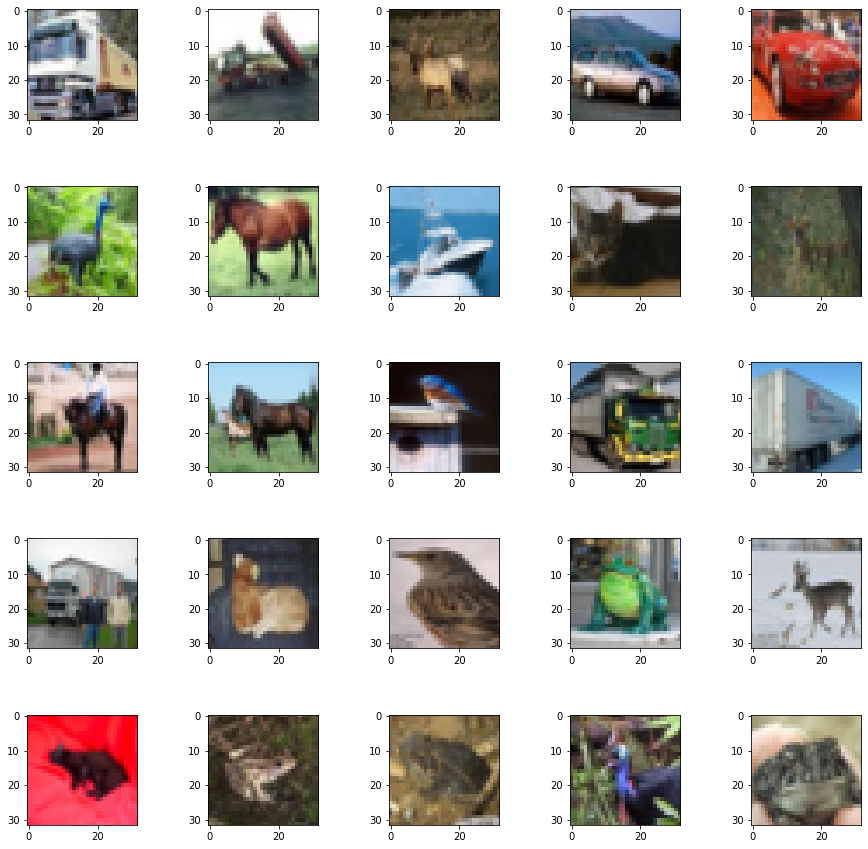

In [2]:
# load train and test dataset
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()

    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def show_example(data, number_of_items):
    size = sqrt(number_of_items)
    size = size if size == int(size) else int(size) + 1
    fig = plt.figure(figsize=(size*3,size*3))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    for i in range(1, number_of_items+1):
        sub = fig.add_subplot(size, size, i)
        sub.imshow(data[i])
    plt.show()

trainX, trainY, testX, testY = load_dataset()
show_example(trainX, 25)

### Test Harness/Test Framework

In order to experiment on the effect of multiple different architectures easily, the [test harness](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) approach by Jason Brownlee was used as a basis to work from.

In [3]:
def get_model_summary(model):
    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

# scale pixels
def data_preparation(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Normalize Values
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0

    return train_norm, test_norm

# plot diagnostic learning curves
def summarize_results(history):
    # Entropy Loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='orange', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.legend(loc='lower left', scatterpoints = 1, frameon=False)
    # Accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='cyan', label='train')
    plt.plot(history.history['val_accuracy'], color='green', label='test')
    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)
    plt.show()

def run_test_harness(model, is_data_augmentation, epochs):
    verbosity=False
    #model_summary()
    # Load data and prepare dataset
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = data_preparation(trainX, testX)

    # Fit the model
    if is_data_augmentation:
        steps = int(trainX.shape[0] / 64)
        iterator = data_augmentation(trainX, trainY)
        history = model.fit(iterator,
                            steps_per_epoch=steps,
                            epochs=10, #hard setting due to Windows 10 TF ptxas bug
                            validation_data=(testX, testY),
                            verbose=verbosity)
    else:
        history = model.fit(trainX, trainY,
                            epochs=epochs,
                            batch_size=64,
                            validation_data=(testX, testY),
                            verbose=verbosity)

    # Evaluate the model
    _, acc = model.evaluate(testX, testY, verbose=verbosity)
    display('Accuracy: ' + str(acc * 100.0))

    summarize_results(history)
    return acc

### Applied models:

#### Optimizers
To allow for comparison between models, the [Keras SGD optimizer](https://keras.io/api/optimizers/sgd/) was applied for all models.

#### LeNet
Implementation based on [this](https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9) default Keras implementation.
During the implementation of LeNet, Keras showed how easily DL Architectures can be implemented: The alternation of convolutions and subsampling steps could easily be implemented by adding Convolusion2D and AveragePooling2D steps.

Initially, MaxPooling2D was tried, but since most models available online explicitly use Average Pooling it was deemed to be closer to the original architecture and changed.

In [4]:
def define_lenet_model():
    model = Sequential()
    model.add(Conv2D(30, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(32, 32, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(13, kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(86, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### VGG Models
Based on the description in [this tutorial](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) a 3 Block VGG model was created:

In [5]:
def define_vgg_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Data Augmentation
Different approaches were applied for data augmentation, starting with only horizontally flipping images to more profound data alterations.
Finally, the one [applied by Lidy](https://github.com/tuwien-musicir/DeepLearning_Tutorial/blob/master/Car_recognition.ipynb) was applied.

In [6]:
def data_augmentation(trainX, trainY):
	#datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

	return datagen.flow(trainX, trainY, batch_size=64)

### Results

'Running estimation for model LeNet with data augmentation False'

'Accuracy: 61.61999702453613'

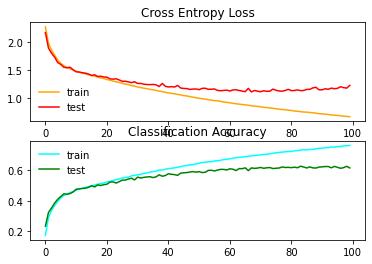

'Time taken for LeNet: 4.331271183490753 minutes'

'Running estimation for model VGG with data augmentation False'

'Accuracy: 73.47999811172485'

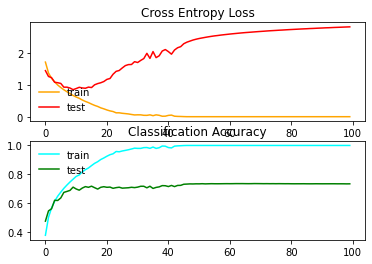

'Time taken for VGG: 13.434623702367146 minutes'

'Running estimation for model LeNet with data augmentation True'

'Accuracy: 61.570000648498535'

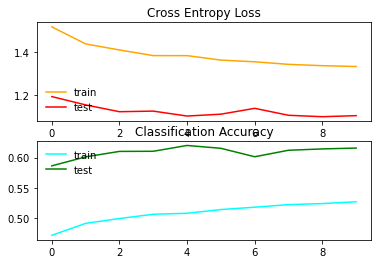

'Time taken for LeNet: 3.1612666567166645 minutes'

'Running estimation for model VGG with data augmentation True'

'Accuracy: 73.989999294281'

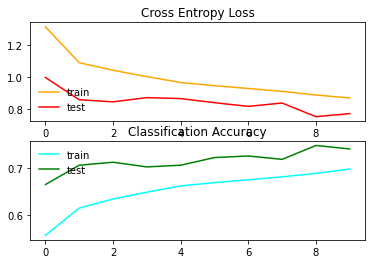

'Time taken for VGG: 3.3862661838531496 minutes'

In [7]:
import time

results = []

# Define models
models = [
    {'name': 'LeNet', 'model': define_lenet_model()},
    {'name': 'VGG', 'model': define_vgg_model()}
    ]
# Data Augmentation Values
data_augmentation_values = [False, True]

# Run models and estimate accuracy
max_epochs = 100
for data_augmentation_value in data_augmentation_values:
    for model in models:
        display("Running estimation for model " + model['name'] +
                " with data augmentation " + str(data_augmentation_value))
        start_time = time.time()
        accuracy = run_test_harness(model['model'], data_augmentation_value, max_epochs)
        end_time = time.time()
        duration = str((end_time - start_time)/60) + " minutes"
        display("Time taken for " + model['name'] + ": " + str((end_time - start_time)/60) + " minutes")

        results.append(pd.Series({
            'model': model['name'],
            'data_augmentation': data_augmentation_value,
            'epochs': 10 if data_augmentation_value else max_epochs,
            'duration': duration,
            'accuracy': accuracy
        }))

### Overall Results

In [8]:
results = pd.DataFrame(results)
display('Overall Results', results)

'Overall Results'

,model,data_augmentation,epochs,duration,accuracy
0,LeNet,False,100,4.331271183490753 minutes,0.6162
1,VGG,False,100,13.434623702367146 minutes,0.7348
2,LeNet,True,10,3.1612666567166645 minutes,0.6157
3,VGG,True,10,3.3862661838531496 minutes,0.7399


#### Effect of DL Architecture
Two different DL Architectures were applied: LeNet and VGG with 3 VGG Blocks. While VGG consistently performed better than LeNet, the differences were surprisingly small.
However, especially the increased runtime for the VGG models have to be taken into account: The models took almost three times as long to calcuclate.
Accuracy was 56% for LeNet and 73% for the VGG model at epoch 20. After this point, there were only very limited gains, until the models had an accuracy of 61.61% (LeNet) respective 73.47% (VGG) at epoch 100.

Congruently, Accuracy increased linear starting from epoch 5 onward and the fact that both the graph for the test set as well as the graph for training as well for validation accuracy are at similar level indicate little to no overfitting of the model at epoch values up to 20 (LeNet) respective 10 (VGG). After this point both models are increasingly overfitting.

As for required resources for training of the models: A maximum of 100 epochs were calculated for both models (without data augmentation due to the current Tensorflow issue on Windows 10 - see below). With only CPU based calculation, especially VGG did not finish in a reasonable amount of time (Intel Core i5-6600K@3.5GHz). Calculation on a GPU (GeForce GTX 970) improved calculation times considerably and made calculation with these epoch values possible.

#### Effects of Data Augmentation
Unfortunately, only low values for epoch could be selected when using data augmentation due to a currently [unresolved issue in Tensorflow with Windows 10](https://github.com/tensorflow/models/issues/7640) which forces model fit/data augmentation on CPU for generated data on non Linux machines.

However, even in this limited epoch range we see a clear effect of data augmentation: With a severly reduced number of epochs, the models yielded comparable results.
Also, several data augmentation approaches were tested: Among the data augmentation approaches tried, the final approach, which is based on the Tutorial provided by Lidy was by far the most extensive one.
Initially, images were only flipped, which led to very limited improvements.
It is highly interesting to see, that in data augmentation setting the model congruently performs better in terms of accuracy when given test data compared to training data, at least in low epoch ranges.

It would have been extremely interesting to see effects of data augmentation for high epoch values and the effect of the overfitting that could be seen in the non augmented model calculations.
However with only CPU calculations the results were impossible to attain in a reasonable amount of time (last run was canceled after three hours).